In [1]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

2024-06-08 07:29:04.688469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 07:29:04.688602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 07:29:04.862037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import os
import random
from sklearn.model_selection import train_test_split
import shutil

# Define paths
data_path = '/kaggle/input/dataset-flood-noflood/Dataset'
labels = ['Flooding', 'No Flooding']
output_path = '/kaggle/working/Dataset_Split'

# Initialize lists to store file paths
all_files = {label: [] for label in labels}

# Collect file paths
for label in labels:
    label_path = os.path.join(data_path, label)
    for file in os.listdir(label_path):
        if file.endswith(('.jpg', '.jpeg')):  # Add other file extensions if needed
            all_files[label].append(os.path.join(label_path, file))

# Shuffle the file paths
for label in labels:
    random.shuffle(all_files[label])

# Combine lists and create labels list for stratification
all_files_combined = all_files['Flooding'] + all_files['No Flooding']
all_labels_combined = [0]*len(all_files['Flooding']) + [1]*len(all_files['No Flooding'])

# Split the dataset into train, validation, and test sets
train_files, val_test_files, train_labels, val_test_labels = train_test_split(
    all_files_combined, all_labels_combined, test_size=0.2, stratify=all_labels_combined
)

val_files, test_files, val_labels, test_labels = train_test_split(
    val_test_files, val_test_labels, test_size=0.5, stratify=val_test_labels
)

# Create directories for train, val, and test splits in the writable directory
split_names = ['train', 'val', 'test']
for split_name in split_names:
    for label in labels:
        os.makedirs(os.path.join(output_path, split_name, label), exist_ok=True)

# Function to copy files to respective directories with debug statements
def copy_files(file_list, label_list, split_name):
    for file_path, label in zip(file_list, label_list):
        label_str = labels[label]
        dest_path = os.path.join(output_path, split_name, label_str, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)
        #print(f"Copied {file_path} to {dest_path}")

# Copy files to respective directories with debug statements
copy_files(train_files, train_labels, 'train')
copy_files(val_files, val_labels, 'val')
copy_files(test_files, test_labels, 'test')

print("Dataset split and files copied successfully!")


Dataset split and files copied successfully!


In [4]:
import os
from PIL import Image

def check_images(directory):
    problematic_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Check if image can be opened
                except (IOError, SyntaxError) as e:
                    print(f"Problematic file: {file_path}, Error: {e}")
                    problematic_files.append(file_path)
    return problematic_files

train_path = '/kaggle/working/Dataset_Split/train'
valid_path = '/kaggle/working/Dataset_Split/val'
test_path = '/kaggle/working/Dataset_Split/test'

print("Checking training images...")
train_problems = check_images(train_path)
print(f"Found {len(train_problems)} problematic images in the training set.")

print("Checking validation images...")
valid_problems = check_images(valid_path)
print(f"Found {len(valid_problems)} problematic images in the validation set.")

print("Checking test images...")
test_problems = check_images(test_path)
print(f"Found {len(test_problems)} problematic images in the test set.")


Checking training images...
Found 0 problematic images in the training set.
Checking validation images...
Found 0 problematic images in the validation set.
Checking test images...
Found 0 problematic images in the test set.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np



def check_preprocessing(directory, preprocessing_function, batch_size=10):
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    generator = datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=batch_size, shuffle=False)
    
    problematic_files = []
    for batch_index in range(len(generator)):
        try:
            images, _ = next(generator)
            # Apply preprocessing function and check output
            preprocessed_images = preprocessing_function(images)
            # Verify that preprocessing does not produce NaNs or Infs
            if np.any(np.isnan(preprocessed_images)) or np.any(np.isinf(preprocessed_images)):
                problematic_files.extend(generator.filenames[batch_index * batch_size : (batch_index + 1) * batch_size])
        except Exception as e:
            print(f"Error during preprocessing: {e}")
            problematic_files.extend(generator.filenames[batch_index * batch_size : (batch_index + 1) * batch_size])
    return problematic_files

train_path = '/kaggle/working/Dataset_Split/train'
valid_path = '/kaggle/working/Dataset_Split/val'
test_path = '/kaggle/working/Dataset_Split/test'

print("Checking preprocessing for training images...")
train_problems = check_preprocessing(train_path, tf.keras.applications.mobilenet.preprocess_input)
print(f"Found {len(train_problems)} problematic images in the training set.")

print("Checking preprocessing for validation images...")
valid_problems = check_preprocessing(valid_path, tf.keras.applications.mobilenet.preprocess_input)
print(f"Found {len(valid_problems)} problematic images in the validation set.")

print("Checking preprocessing for test images...")
test_problems = check_preprocessing(test_path, tf.keras.applications.mobilenet.preprocess_input)
print(f"Found {len(test_problems)} problematic images in the test set.")


Checking preprocessing for training images...
Found 13604 images belonging to 2 classes.
Found 0 problematic images in the training set.
Checking preprocessing for validation images...
Found 1701 images belonging to 2 classes.
Found 0 problematic images in the validation set.
Checking preprocessing for test images...
Found 1701 images belonging to 2 classes.
Found 0 problematic images in the test set.


In [6]:
from pathlib import Path
import imghdr



image_extensions = [".jpeg", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
def check_and_remove_images(directory):
    for filepath in Path(directory).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image. Removing.")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow. Removing.")
                os.remove(filepath)
check_and_remove_images(train_path)
check_and_remove_images(valid_path)
check_and_remove_images(test_path)

/kaggle/working/Dataset_Split/train/Flooding/flood_3.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/Flooding/flood_5435.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/clean_62.jpg is a webp, not accepted by TensorFlow. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/clean_111.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/00000051_(3).jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/dirty_47.jpg is a webp, not accepted by TensorFlow. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/clean_51.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/dirty_36.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/clean_27.jpg is a webp, not accepted by TensorFlow. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/img_0135.jpg is not an image. Removing.
/kaggle/working/Dataset_Split/train/No Flooding/clean_

In [7]:
#train_path = '/kaggle/input/imagedataset/data/train'
#valid_path = '/kaggle/input/imagedataset/data/valid'
#test_path = '/kaggle/input/imagedataset/data/test'
train_path = '/kaggle/working/Dataset_Split/train'
valid_path = '/kaggle/working/Dataset_Split/val'
test_path = '/kaggle/working/Dataset_Split/test'

# Parameters
batch_size = 10
img_size = (224, 224)

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical', # Assuming a classification task
    shuffle=True
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

# Preprocessing function
def preprocess(image, label):
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess)
valid_dataset = valid_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Prefetching to improve performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)



Found 13579 files belonging to 2 classes.
Found 1694 files belonging to 2 classes.
Found 1697 files belonging to 2 classes.


In [8]:
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)

/tmp/ipykernel_33/1498720353.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
#x = mobile.layers[-12].output


In [10]:
from tensorflow.keras.regularizers import l2
x = mobile.layers[-12].output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [11]:
model = Model(inputs=mobile.input, outputs=output)

In [12]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,159,810 (8.24 MB)

 Trainable params: 1,333,762 (5.09 MB)

 Non-trainable params: 826,048 (3.15 MB)

In [14]:
#pip install --upgrade tensorflow_ranking

In [15]:
#import tensorflow.compat.v1 as tf1
#import tensorflow_ranking as tfr


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [17]:

#train_steps_per_epoch = len(train_dataset) // batch_size
#val_steps = len(valid_dataset) // batch_size


# Train the model with the custom callback

history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 462s 299ms/step - accuracy: 0.7896 - loss: 1.2643 - val_accuracy: 0.7828 - val_loss: 0.6094
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 403s 297ms/step - accuracy: 0.9073 - loss: 0.3319 - val_accuracy: 0.9091 - val_loss: 0.2788
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 397s 292ms/step - accuracy: 0.9281 - loss: 0.2238 - val_accuracy: 0.9156 - val_loss: 0.2788
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 389s 286ms/step - accuracy: 0.9511 - loss: 0.1548 - val_accuracy: 0.9185 - val_loss: 0.2631
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 404s 298ms/step - accuracy: 0.9721 - loss: 0.0947 - val_accuracy: 0.9144 - val_loss: 0.3712
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 439s 296ms/step - accuracy: 0.9779 - loss: 0.0750 - val_accuracy: 0.9115 - val_loss: 0.3048
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 432s 288ms/step - accuracy: 0.9853 - loss: 0.0523 - val_accuracy: 0.9168 - val_loss: 0.3535


In [18]:
model.save("fine_tuned_flood_recognition_model1.h5")

170/170 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.9349 - loss: 0.1764
Test loss: 0.22821412980556488, Test accuracy: 0.9210371375083923


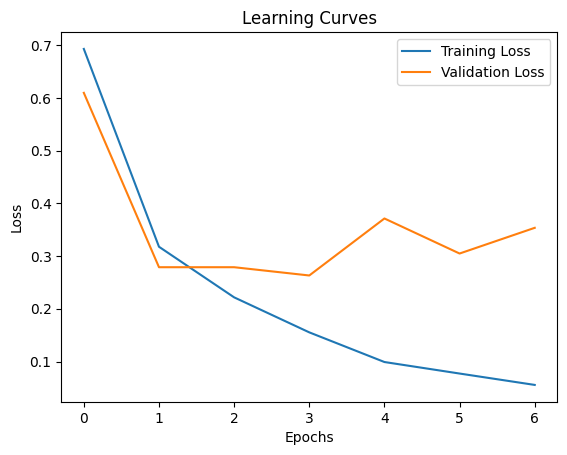

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

# Plot learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.show()

Precision: 0.9224804327657548
F1 Score: 0.9209561389684963
Accuracy: 0.9210371243370654
Confusion matrix, without normalization
[[811  42]
 [ 92 752]]


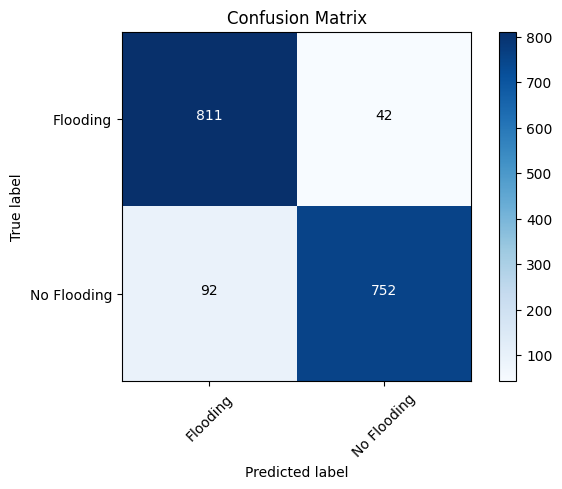

In [20]:
test_dir = '/kaggle/working/Dataset_Split/test'
class_names = sorted(os.listdir(test_dir))

# Get true labels from the directory structure
true_labels = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    for filename in os.listdir(class_dir):
        true_labels.append(class_names.index(class_name))

true_labels = np.array(true_labels)

# Get predictions from the model
predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

# Compute precision, F1 score, and accuracy
precision = precision_score(y_true=true_labels, y_pred=predicted_labels, average='weighted')
f1 = f1_score(y_true=true_labels, y_pred=predicted_labels, average='weighted')
accuracy = accuracy_score(y_true=true_labels, y_pred=predicted_labels)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define class names
cm_plot_labels = ['Flooding', 'No Flooding']

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Show the plot
plt.show()

In [21]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9224804327657548
F1 Score:  <function f1_score at 0x7b6ca0e660e0>
Accuracy:  0.9210371243370654


In [22]:
#model = tf.keras.models.load_model('path_to_your_model.h5')

In [23]:
from tensorflow.keras.preprocessing import image
def preprocess_image(filename):
    img_path = "/kaggle/input/testset/testset_images/testset_images"
    img = image.load_img(img_path + '/' + str(filename) + ".jpg", target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [24]:
#from IPython.display import Image
#Image(filename='data\lu.jpg', width=300,height=200) 

In [25]:
#import tensorflow as tf
#model = tf.keras.models.load_model('/kaggle/input/finetuned-model/fine_tuned_flood_recognition_model.h5')

In [26]:
import numpy as np
import pandas as pd
test_csv = pd.read_csv("/kaggle/input/testdata/test.csv")
image_id = test_csv['image_id']
id_test = []
for id_ in image_id:
    id_test.append(id_)


In [27]:

labels = ['Flooding', 'No Flooding']

label_test = []
for i in id_test:
        # Preprocess the image
        preprocessed_image = preprocess_image(i)
        
        # Make predictions
        predictions = model.predict(preprocessed_image)
        result = np.argmax(predictions)
        #result = predictions
        final_result = labels[result]
        # Remove '.jpg' from the filename to get the ID
        
        
        # Append the results to the lists
        
        label_test.append(final_result)
        #label_test.append(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [28]:
#predictions

In [29]:
#result = np.argmax(predictions)

In [30]:
#labels[result]

In [31]:
results_df = pd.DataFrame({'id': id_test, 'label': label_test})
#results_df.to_csv(output_csv, index=False)
results_df

,id,label
0,3483809003,Flooding
1,3712805295,No Flooding
2,379845620,No Flooding
3,7343264988,Flooding
4,3843337492,Flooding
...,...,...
1315,6452132743,No Flooding
1316,244899140,No Flooding
1317,3073018258,Flooding
1318,49525361,No Flooding


In [32]:
results_df.to_csv("submiss_08_06_2.csv",index=False) 


In [33]:
#preprocess_image(3712805295)
#pred = model.predict(preprocess_image(3712805295))
#np.argmax(model.predict(preprocess_image(3712805295)))
#pred[1]
#labels[np.argmax(model.predict(preprocess_image(3712805295)))]